In [2]:
# Setup
import sys
import numpy as np
import tensorflow as tf
import Utils.PokemonUtils as pkmnUtils
from matplotlib import pyplot as plt
from Models import Baseline
import importlib

utils = pkmnUtils.PokemonUtils(rel_loc="")

# Only run if split file has not already been generated
if False:
    utils.loadAllGIFs()
    
utils.localLoadAllGifs("Data/SplitsV2.npz")
x_train, x_val, x_test, y_train, y_val, y_test = utils.getSplits()

USE_GPU = False
if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

Instructions for updating:
Use the retry module or similar alternatives.
x_train: (6010, 128, 128, 4)
x_val:   (1510, 128, 128, 4)
x_test:  (1880, 128, 128, 4)
y_train: (6010,)
y_val:   (1510,)
y_test:  (1880,)


In [ ]:
# Run on PokemonUtils update
import Utils.PokemonUtils as pkmnUtils
importlib.reload(pkmnUtils)  # update import if PokemonUtils.py changes
utils = pkmnUtils.PokemonUtils(utils=utils)

In [8]:
x_train_s = x_train.astype('float32') 
x_val_s = x_val[0::10].astype('float32') 
x_test_s = x_test[0::10].astype('float32')
y_train_s = y_train
y_val_s = y_val[0::10]
y_test_s = y_test[0::10]

# display these images (range 0-1 necessary for imshow)
x_train_i = (x_train_s) / 255
x_val_i   = (x_val_s)   / 255
x_test_i  = (x_test_s)  / 255

x_mean = np.mean(x_train_s)
x_train_s = (x_train_s - x_mean) / 255
x_val_s   = (x_val_s - x_mean)   / 255
x_test_s  = (x_test_s - x_mean)  / 255

print("Data normalization:")
print("mean:", x_mean)
print("max: ", np.max(x_train_s))
print("min: ", np.min(x_train_s))
print("Data shapes:")
print("x_train_s:", x_train_s.shape)
print("x_val_s:  ", x_val_s.shape)
print("x_test_s: ", x_test_s.shape)
print("y_train_s:", y_train_s.shape)
print("y_val_s:  ", y_val_s.shape)
print("y_test_s: ", y_test_s.shape)

Data normalization:
mean: 26.632238
max:  0.89555985
min:  -0.10444015
Data shapes:
x_train_s: (6010, 128, 128, 4)
x_val_s:   (151, 128, 128, 4)
x_test_s:  (188, 128, 128, 4)
y_train_s: (6010,)
y_val_s:   (151,)
y_test_s:  (188,)


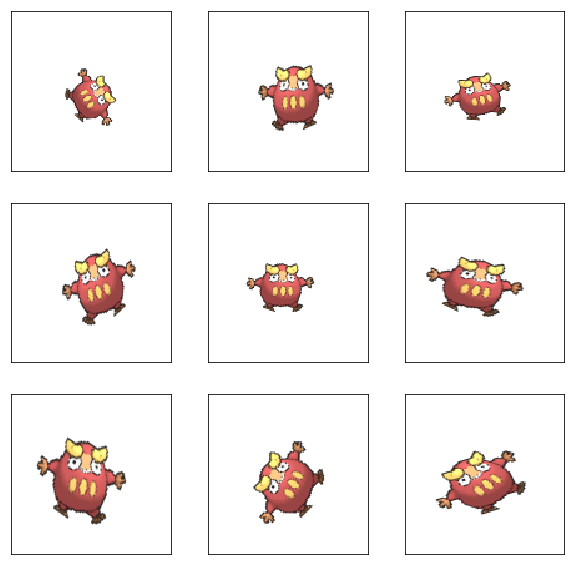

In [9]:
# Functions / objects necessary to train a model
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import skimage.color as color

def oneHot(y, cols=None):
    if (cols < 1):
        cols = np.max(y)
    n = y.shape[0]
    z = np.zeros((n, cols))
    z[np.arange(n), (y-1)] = 1
    return z


data_aug = ImageDataGenerator(
    rotation_range=50,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest"
)

image = x_train_i[0,:,:,:]
image = image.reshape((1,) + image.shape)

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3,3)

i = 0
for batch in data_aug.flow(image, batch_size=1):
    ax = plt.subplot(gs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(batch[0])
    i += 1
    if i >= 9:
        break

In [67]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import regularizers

use_baseline = False
model = None

def getInitialModel(use_baseline, reg=0, drop=0.5):
    if use_baseline:
        model = Sequential([
                Conv2D(32, (5, 5), input_shape=(128,128,4)),
                Activation("relu"),
                MaxPooling2D((2,2)),

                Conv2D(64, (5, 5)),
                Activation("relu"),
                MaxPooling2D((2,2)),

                Flatten(),

                Dense(64),
                Activation("relu"),
                Dense(18),
                Activation("softmax")
            ])
    else:
        print("Model params: drop =", drop, ", reg =", reg)
        model = Sequential([
                Conv2D(32, (5, 5), input_shape=(128,128,4), padding='same', kernel_regularizer=regularizers.l2(reg)),
                Activation("relu"),
                MaxPooling2D((2,2)),

                Conv2D(64, (5, 5), padding='same', kernel_regularizer=regularizers.l2(reg)),
                Activation("relu"),
                MaxPooling2D((2,2)),

                Flatten(),

                Dense(64, kernel_regularizer=regularizers.l2(reg)),
                Activation("relu"),
                Dropout(drop),
                Dense(18, kernel_regularizer=regularizers.l2(reg)),
                Activation("softmax")
            ])
    return model
  
model = getInitialModel(False, reg=1e-3, drop=.45)

Model params: drop = 0.45 , reg = 0.001


In [68]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [69]:
# Training
batch_size = 64
aug_factor = 10
history = model.fit_generator(
    data_aug.flow(x_train_s, oneHot(y_train_s, 18), batch_size=batch_size),
    epochs=3,
    verbose=1,
    validation_data=(x_val_s, oneHot(y_val_s, 18)),
    steps_per_epoch=x_train_s.shape[0] // batch_size * aug_factor
)
model.save("./Models/neuralmon_model_3.hdf5")

Epoch 1/3
930/930 [==============================] - 1708s 2s/step - loss: 2.5342 - acc: 0.2222 - val_loss: 2.7181 - val_acc: 0.2384
Epoch 2/3
930/930 [==============================] - 1731s 2s/step - loss: 2.2000 - acc: 0.3287 - val_loss: 2.9061 - val_acc: 0.2517
Epoch 3/3
930/930 [==============================] - 1698s 2s/step - loss: 2.0592 - acc: 0.3727 - val_loss: 3.0756 - val_acc: 0.1788


In [154]:
history2 = model.fit_generator(
    data_aug.flow(x_train_s, oneHot(y_train_s, 18), batch_size=batch_size),
    epochs=20,
    verbose=1,
    validation_data=(x_val_s, oneHot(y_val_s, 18)),
    steps_per_epoch=x_train_s.shape[0] // batch_size * aug_factor,
    initial_epoch = 15
)
# model.save("./Models/neuralmon_model_2.2.hdf5")

Epoch 16/20
  2/930 [..............................] - ETA: 28:05 - loss: 0.6128 - acc: 0.7734

KeyboardInterrupt: 

In [153]:
from keras.models import load_model
# model.load_weights("./Models/neuralmon_model_2.hdf5")
model = load_model("./Models/neuralmon_model_3.hdf5")

In [70]:
h = {}
h = history.history
# for k in history.history.keys():
#     h[k] = history.history[k] + history2.history[k]

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


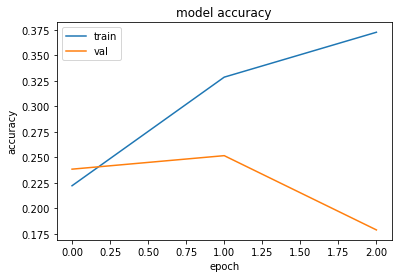

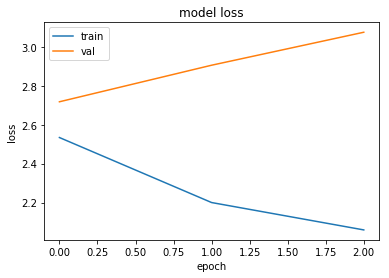

In [71]:
# list all data in history
print(h.keys())

# summarize history for accuracy
plt.plot(h['acc'])
plt.plot(h['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [72]:
pred_train_s = model.predict(x_train_s)
print('Done!')
pred_val_s = model.predict(x_val_s)
print('Done!')
pred_train = model.predict(x_train.astype('float32')/255)
print('Done!')
pred_val = model.predict(x_val.astype('float32')/255)
print('Done!')

Done!
Done!
Done!
Done!


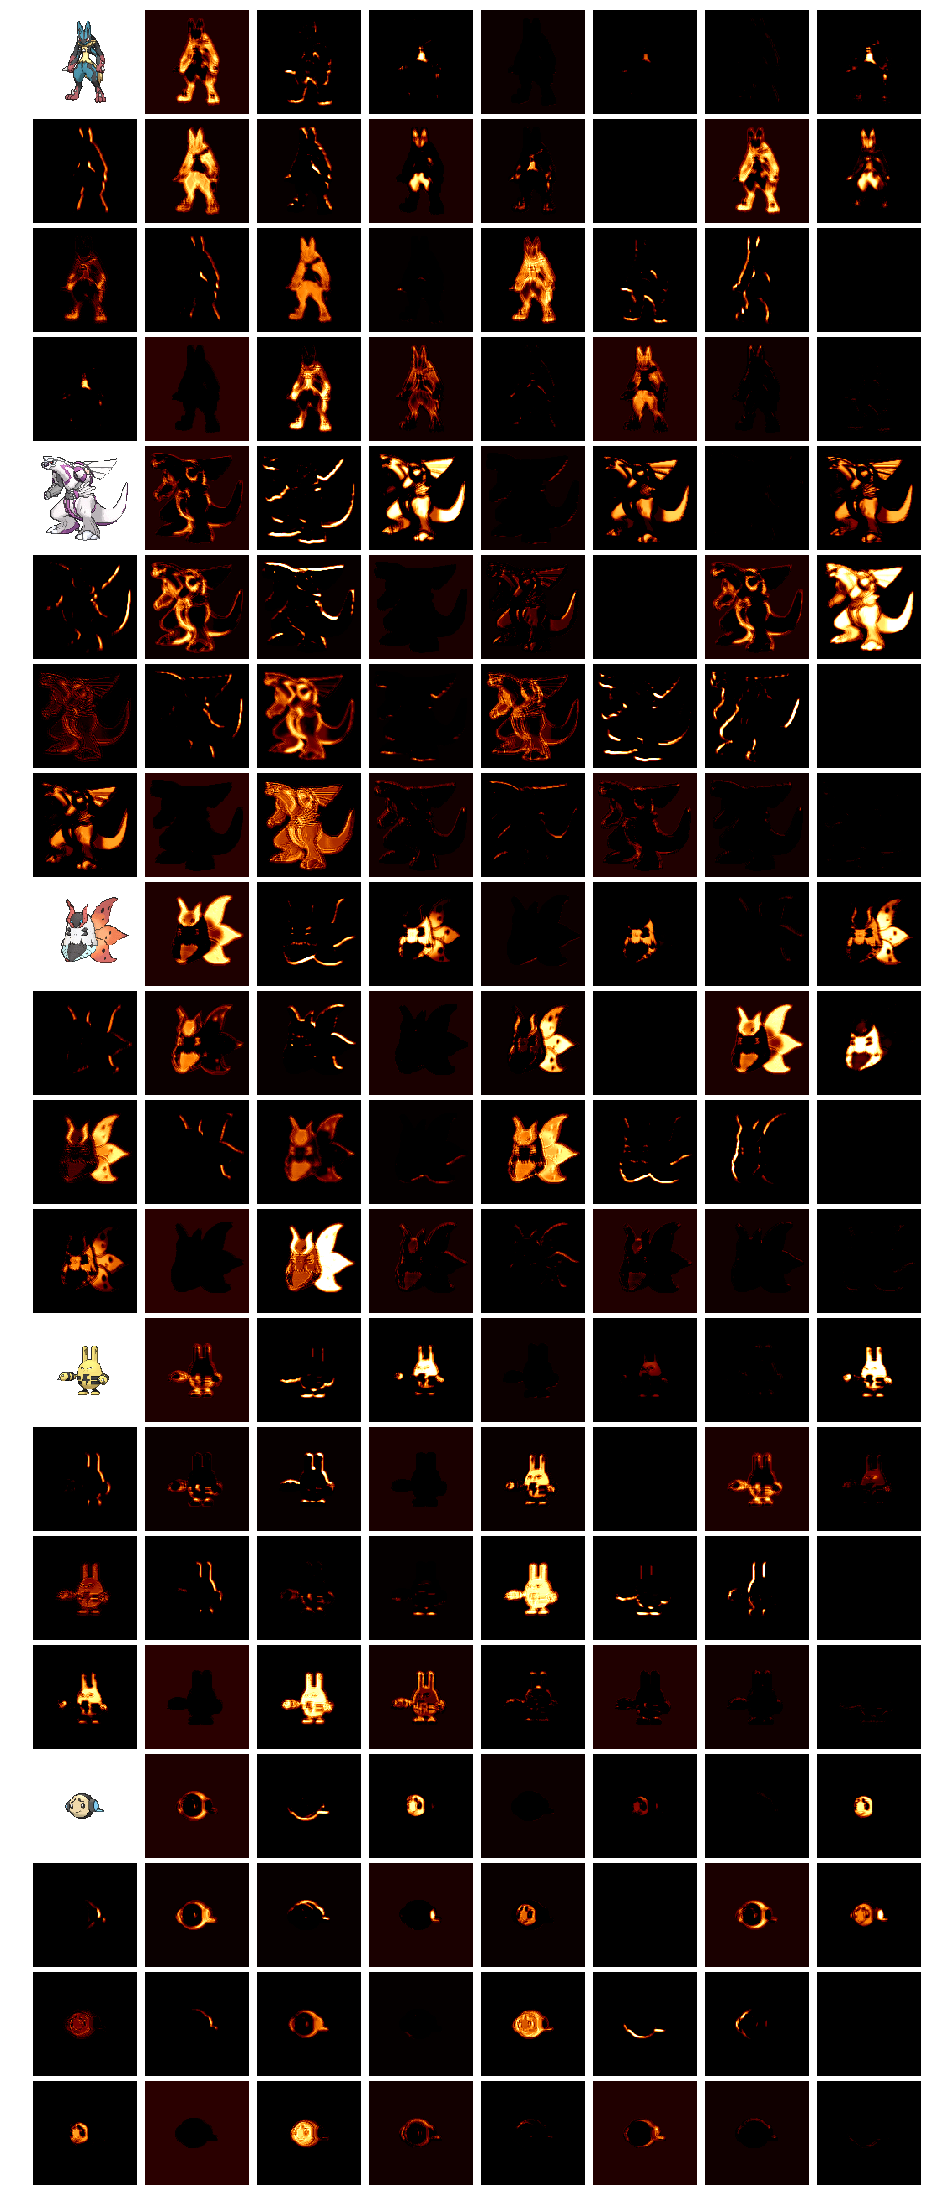

In [73]:
# we build a new model with the activations of the old model
# this model is truncated after the first layer
model_trunc = Sequential([
    Conv2D(32, (5, 5), input_shape=(128,128,4), weights=model.layers[0].get_weights()),
    Activation("relu")
])

start = 0
num = 5
step = 1

plt.figure(figsize=(16,8*num))
gs = gridspec.GridSpec(num*4,8)
gs.update(wspace=0.025, hspace=0.05)

idx = 0
for j in range(start, start+num, step):
    activations = model_trunc.predict(x_val_s[j].reshape(1,128,128,4))
    for i in range(0,32):        
        layer_filter = activations.reshape([124,124,32])[:,:,i]
        ax = plt.subplot(gs[32*idx+i])
        plt.axis("off")  
        if i == 0:
            plt.imshow(x_val_i[j])
        else:
            plt.imshow(layer_filter,cmap="afmhot",vmin=0, vmax=1)
    idx += 1

In [74]:
# Get secondary typing 
y_train_2, y_val_2, y_test_2 = utils.getSecondaryTypeLabels()

y_train_2: (6010,)
y_val_2:   (1510,)
y_test_2:  (1880,)


In [75]:
# Averages scores across frames of pokemon's animation
def customPredict(scores, y, y2=None, frames=10):
    # Averaging
    N, T = scores.shape
    scores_reshaped = scores.reshape((N//10, 10, T))
    avg_scores = np.mean(scores_reshaped, axis=1)
    
    # Primary accuracy
    predictions = np.argmax(avg_scores, axis=1)
    matches = predictions == y-1  # y is 1-indexed
    acc1 = np.sum(matches)/len(matches)
    
    acc2 = None
    if not y2 is None:
        matches2 = predictions == y2-1
        acc2 = np.sum(matches + matches2)/len(matches)  # + acts as an or operator
    
    # Dual accuracy
    return (acc1, acc2, avg_scores)
    

train_acc, train_acc_2, train_avg_scores = customPredict(pred_train, y_train[::10], y2=y_train_2[::10])
val_acc, val_acc_2, val_avg_scores = customPredict(pred_val, y_val[::10], y2=y_val_2[::10])
print("Train accuracy primary:       ", train_acc)
print("Validation accuracy primary:  ", val_acc)
print("Train accuracy secondary:     ", train_acc_2)
print("Validation accuracy secondary:", val_acc_2)

Train accuracy primary:        0.5540765391014975
Validation accuracy primary:   0.17880794701986755
Train accuracy secondary:      0.5723793677204659
Validation accuracy secondary: 0.23841059602649006


In [77]:
import Utils.PokemonPlot as pp
importlib.reload(pp)  # update import for changes

<module 'Utils.PokemonPlot' from '/home/zack/pokemon-learning/Utils/PokemonPlot.py'>

Train predictions


/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


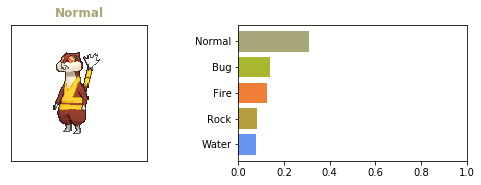

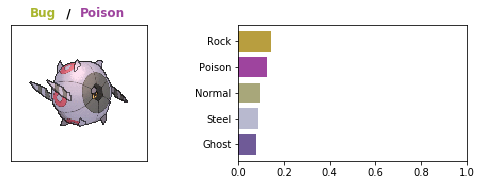

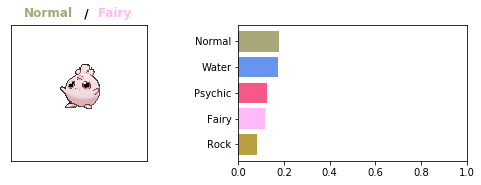

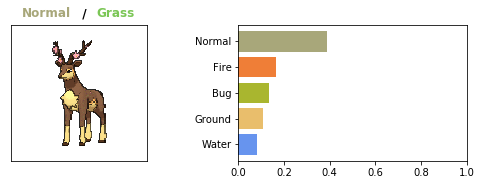

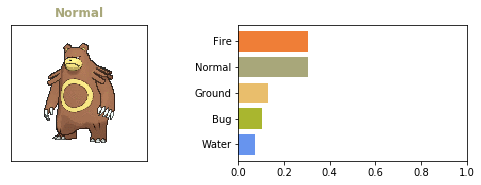

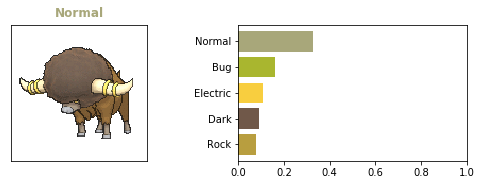

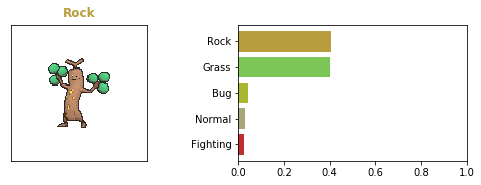

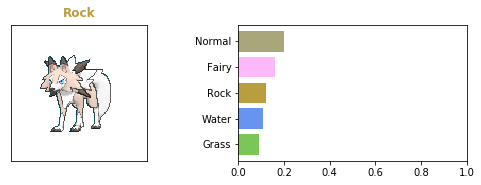

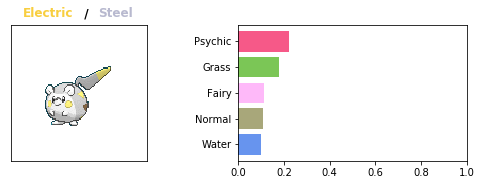

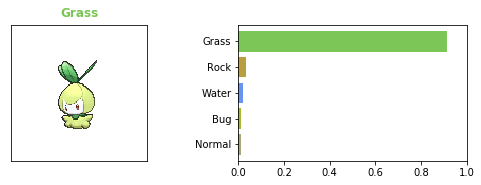

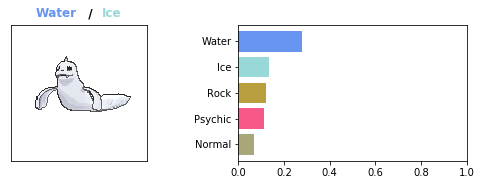

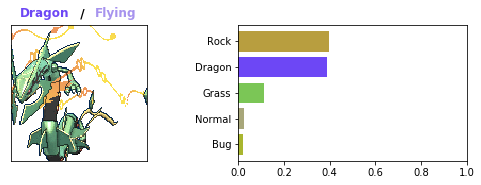

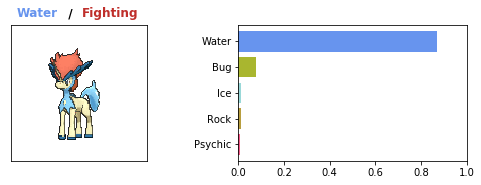

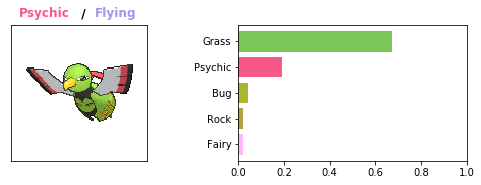

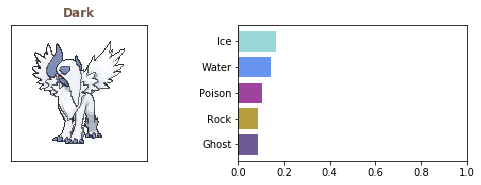

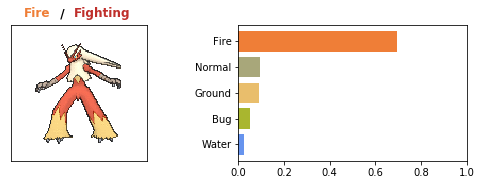

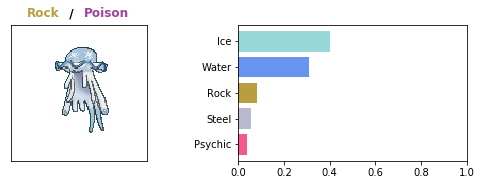

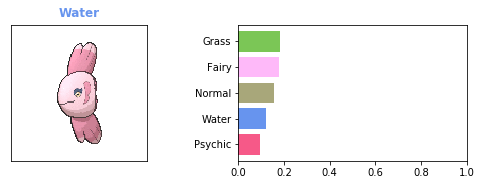

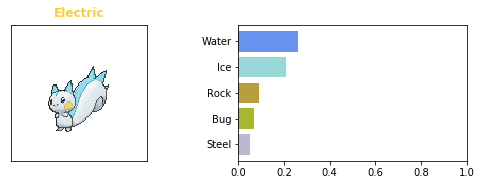

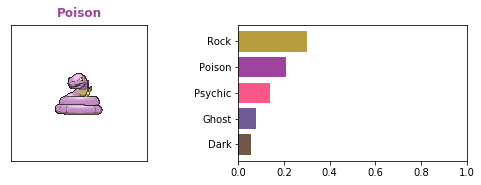

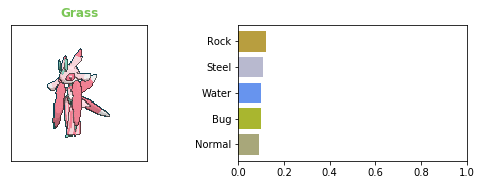

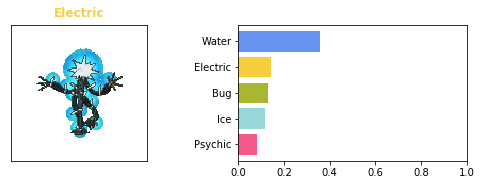

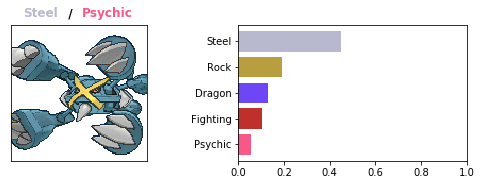

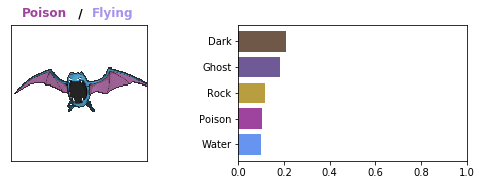

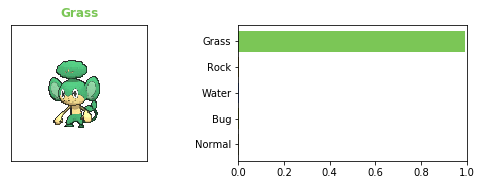

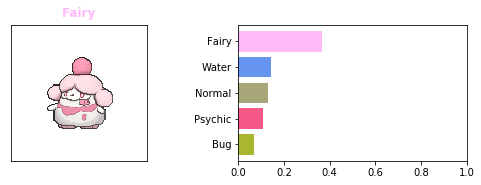

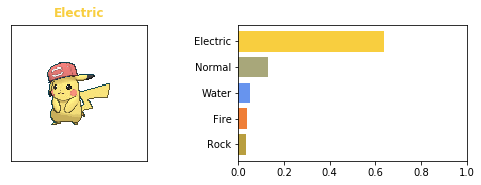

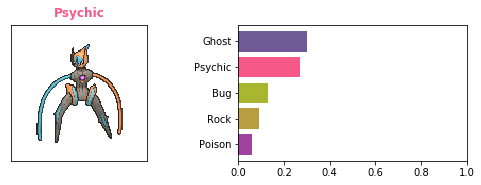

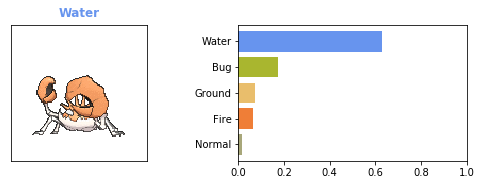

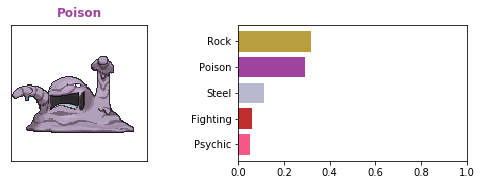

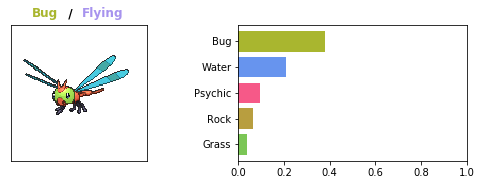

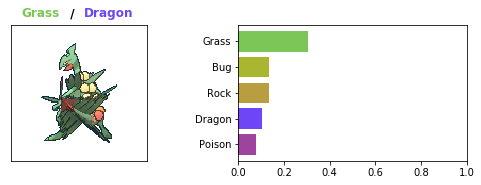

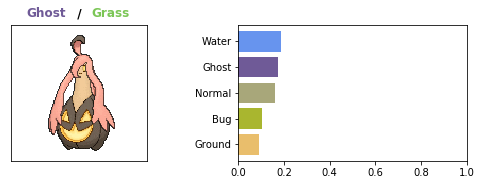

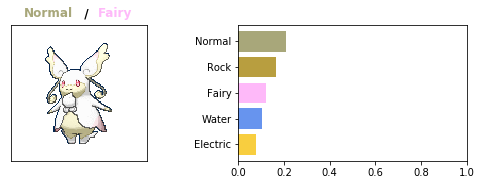

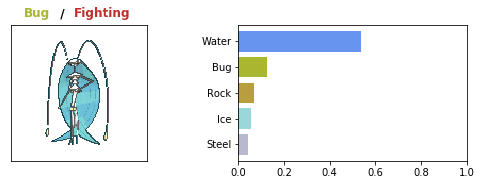

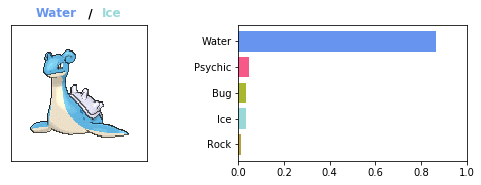

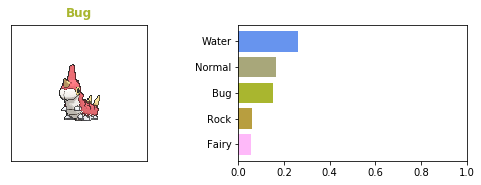

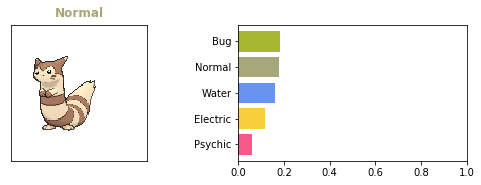

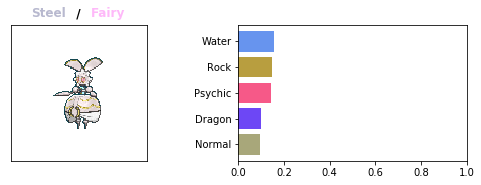

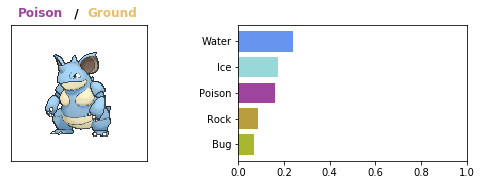

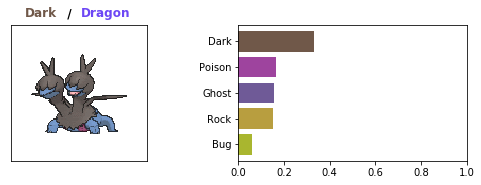

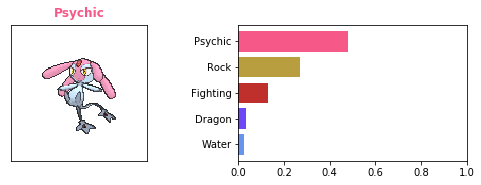

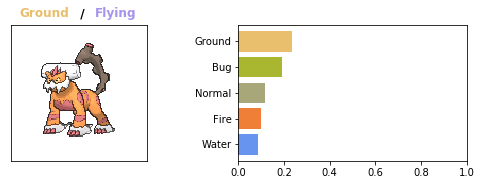

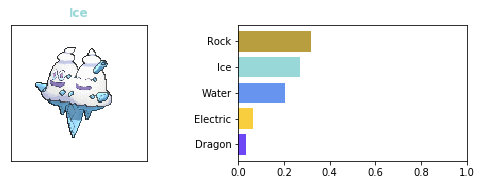

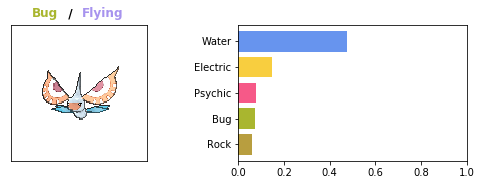

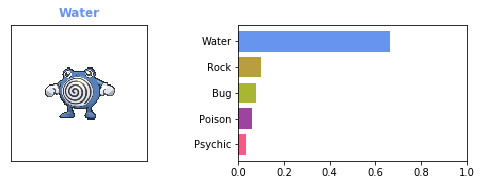

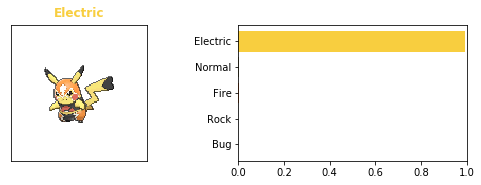

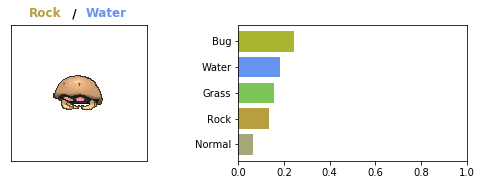

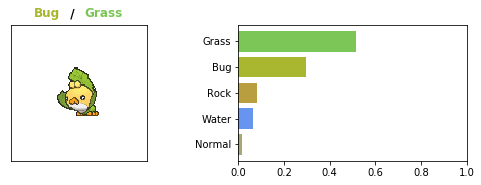

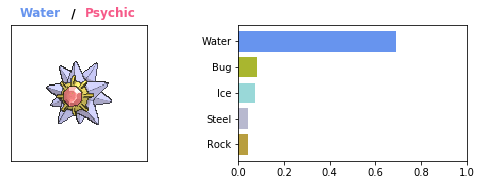

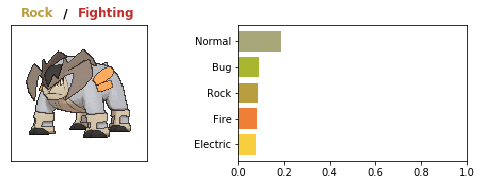

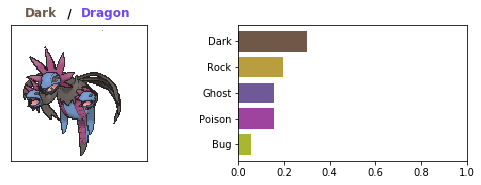

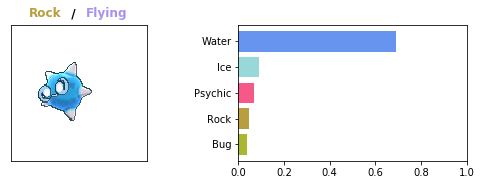

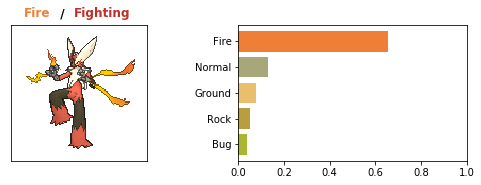

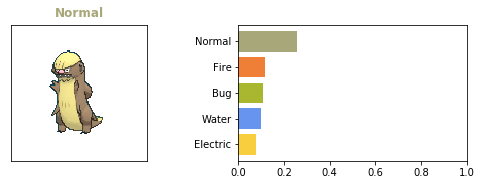

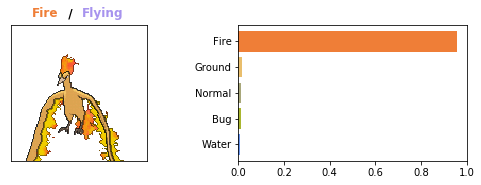

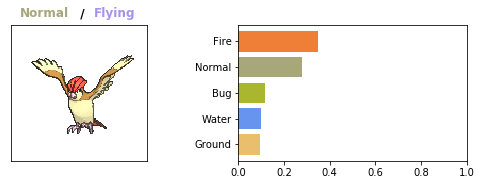

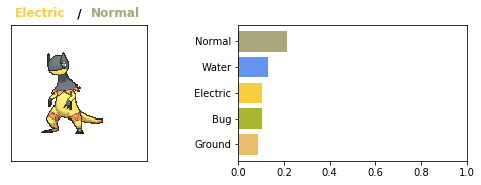

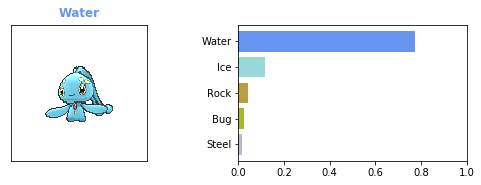

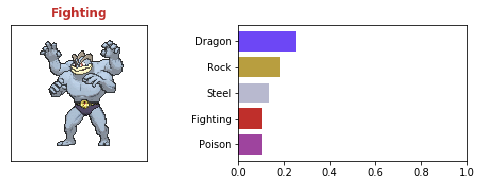

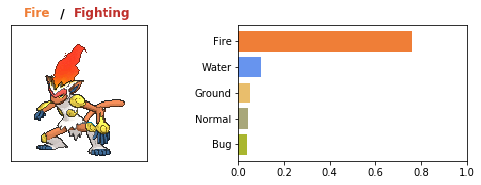

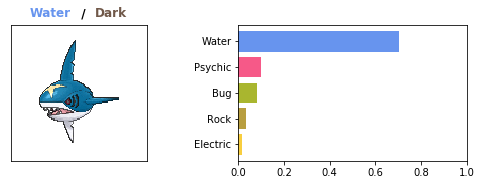

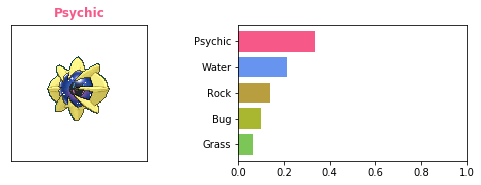

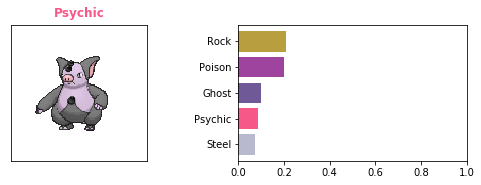

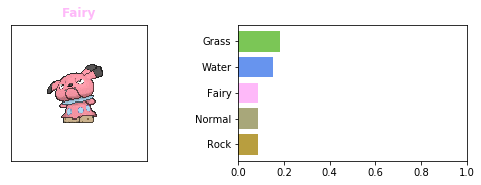

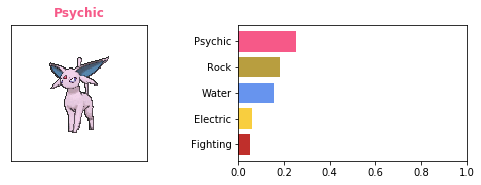

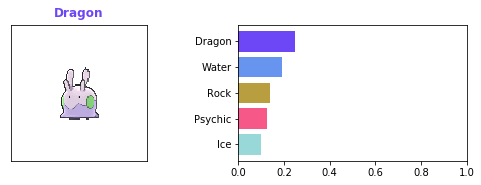

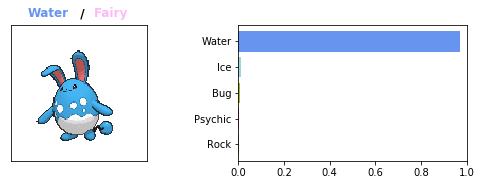

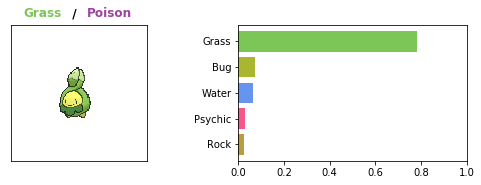

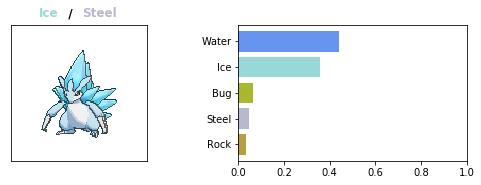

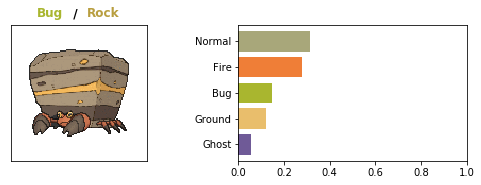

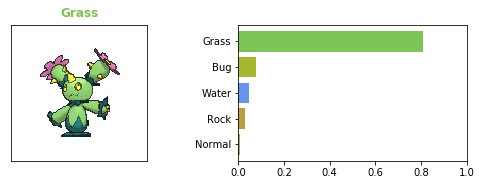

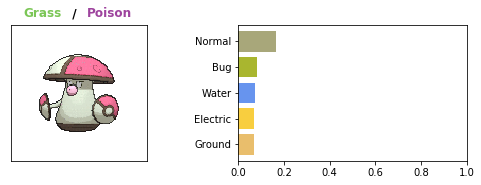

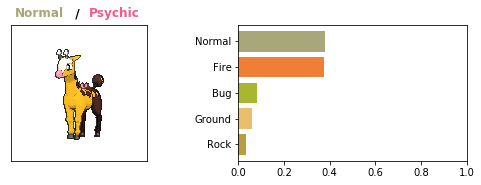

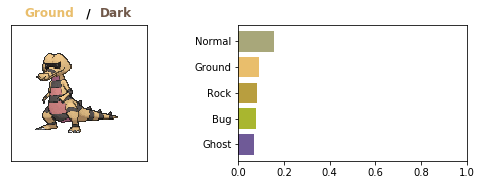

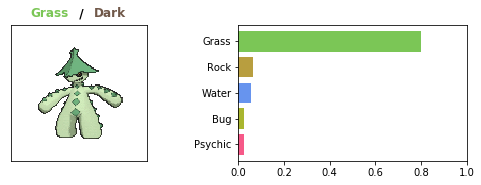

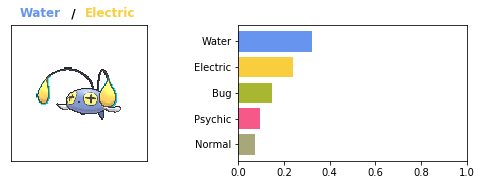

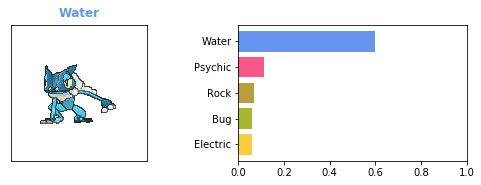

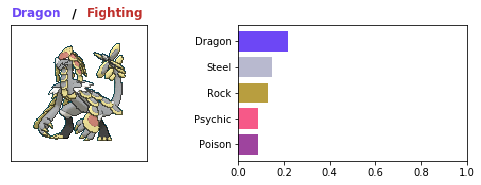

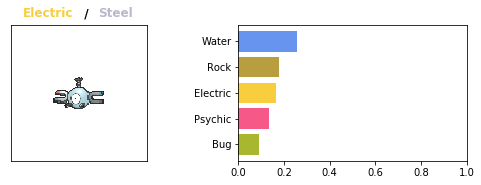

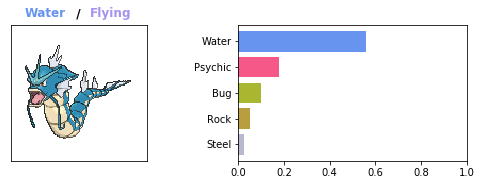

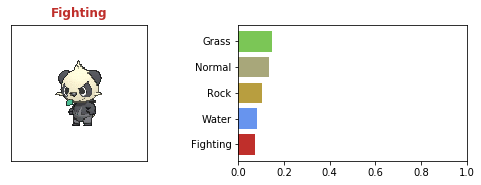

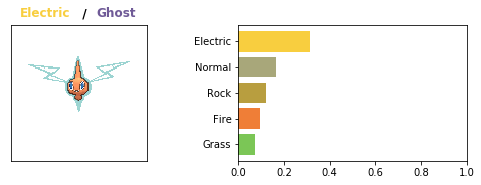

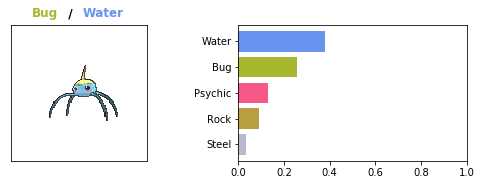

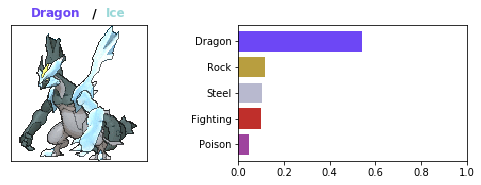

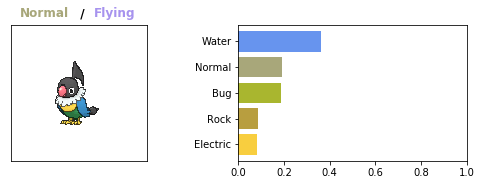

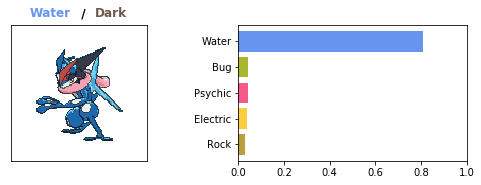

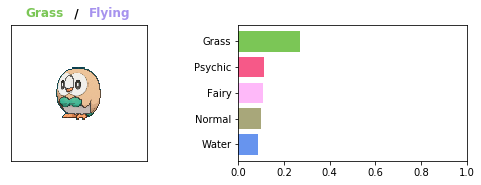

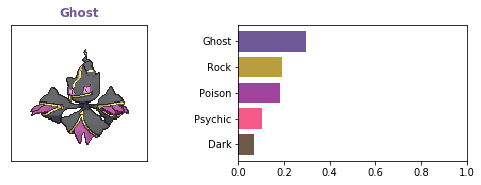

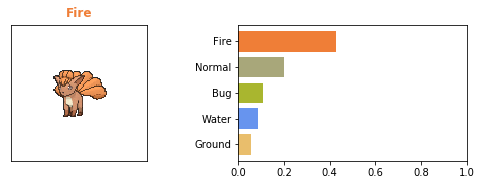

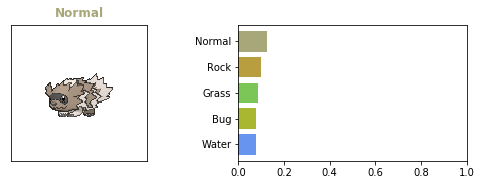

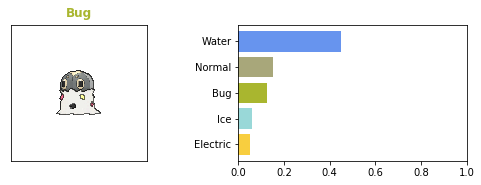

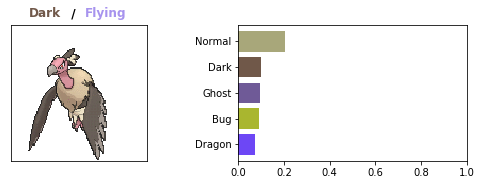

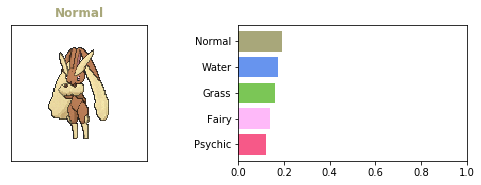

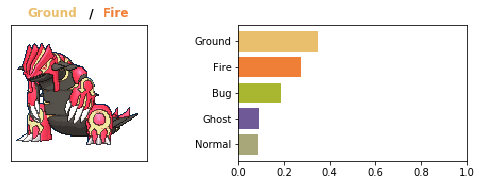

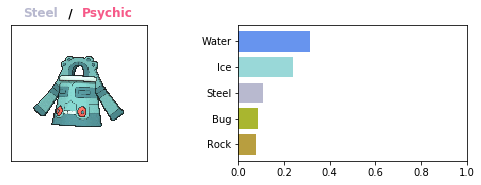

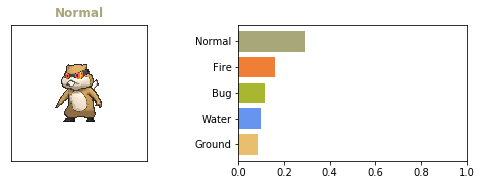

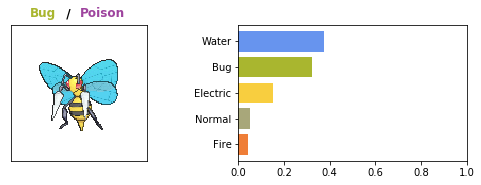

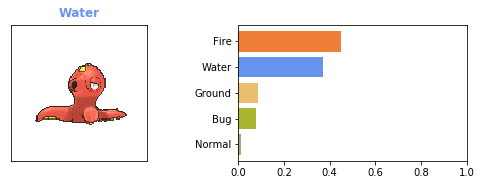

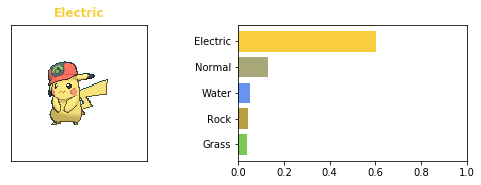

In [80]:
start = 100  # start index
num = 100    # number of images to display
step = 10  # number of frames / pokemon animation

print("Train predictions")
pp.plotPredictions(x_train_i[start*step:(start+num)*step:step],
                   y_train_s[start*step:(start+num)*step:step],
                   train_avg_scores[start:start+num:1], k=5, y2=y_train_2[start*step:(start+num)*step:step])

Validation predictions


/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


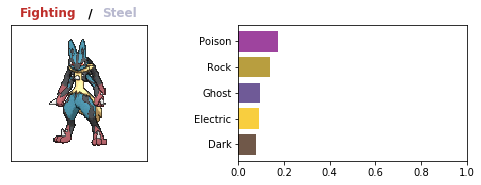

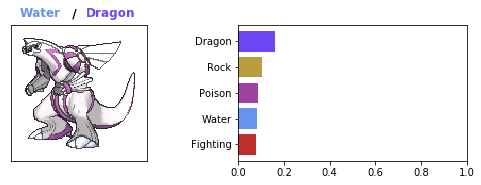

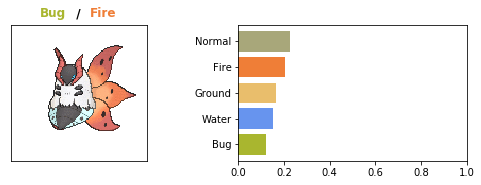

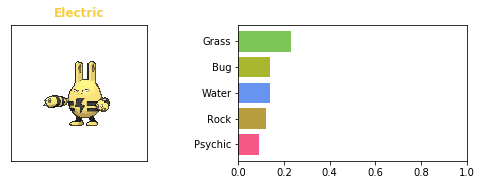

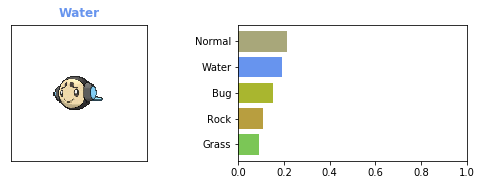

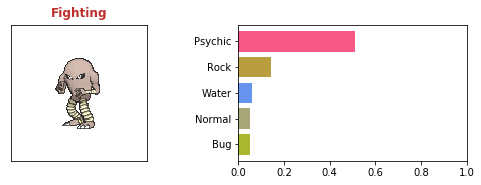

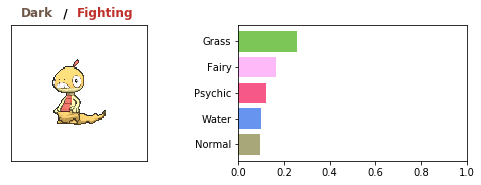

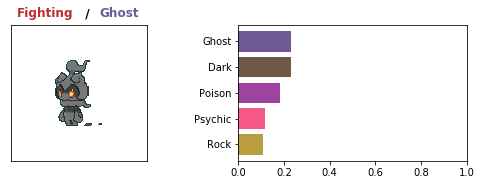

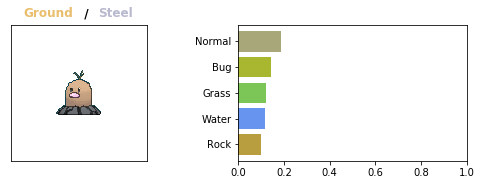

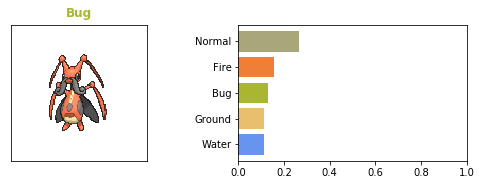

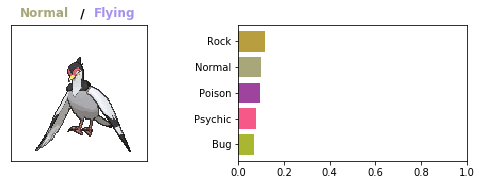

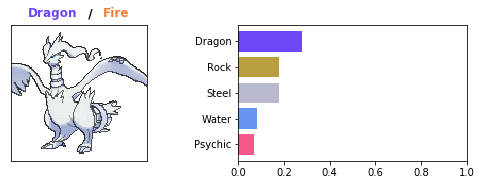

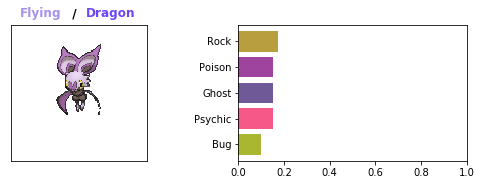

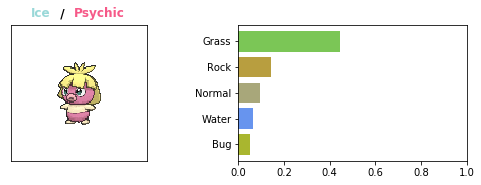

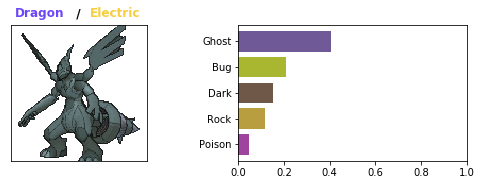

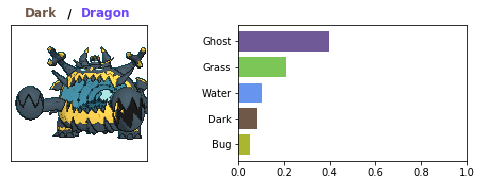

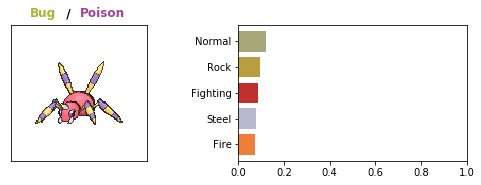

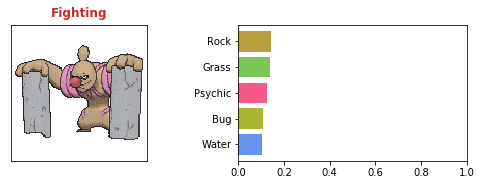

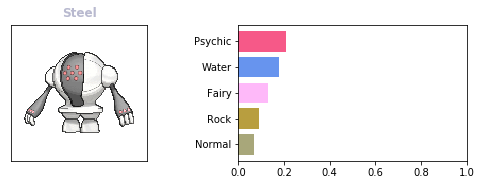

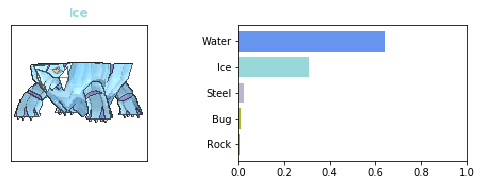

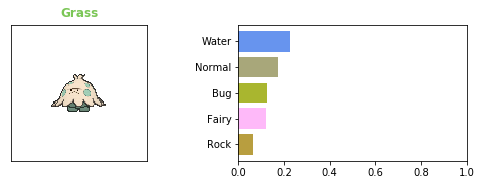

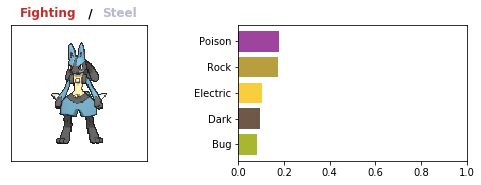

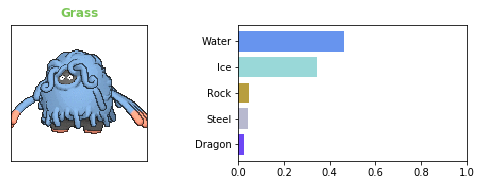

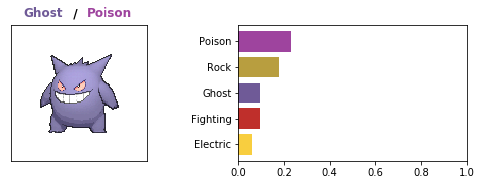

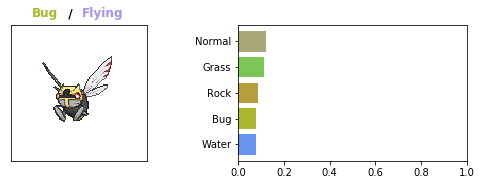

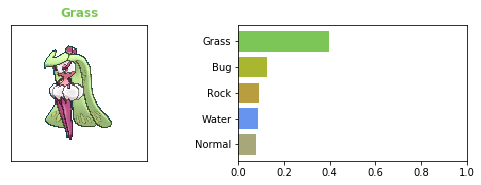

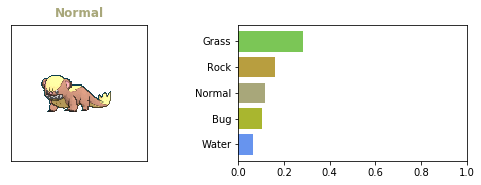

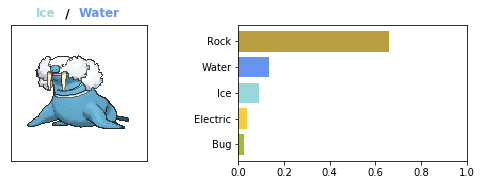

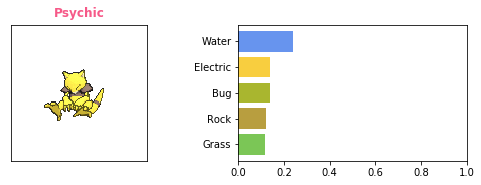

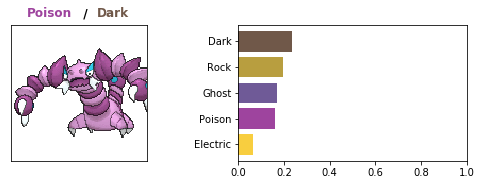

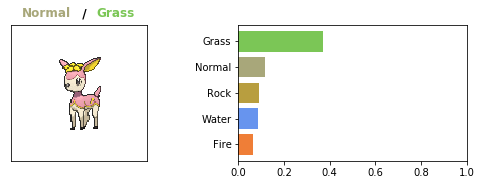

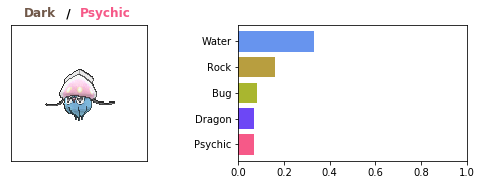

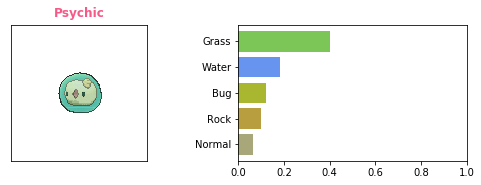

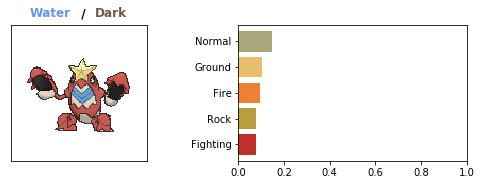

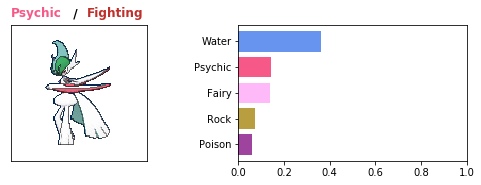

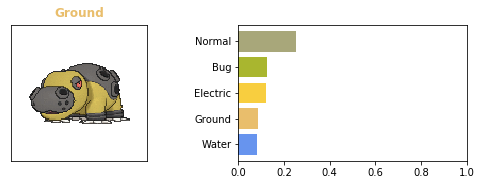

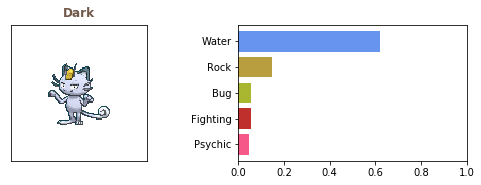

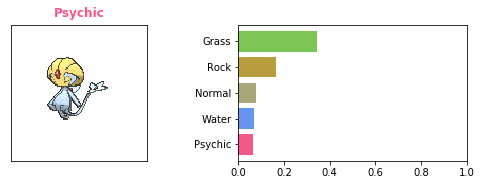

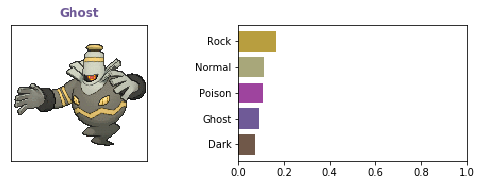

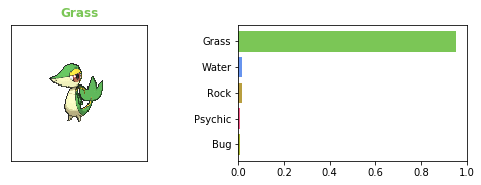

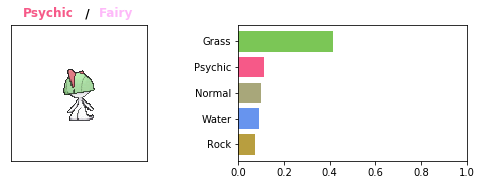

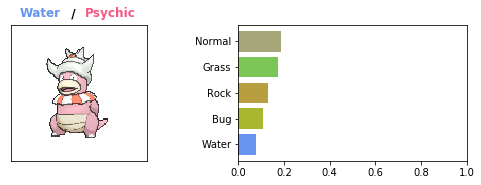

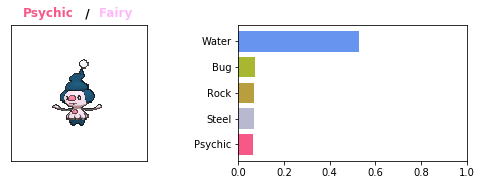

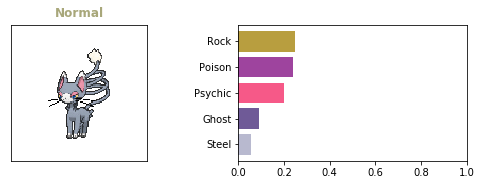

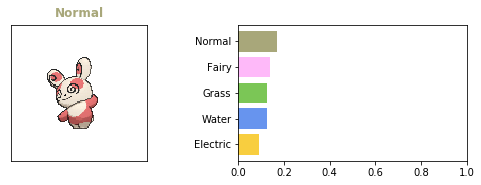

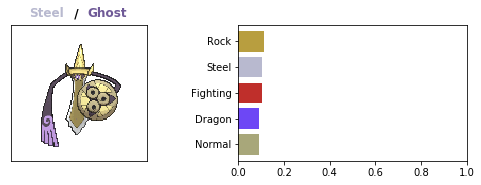

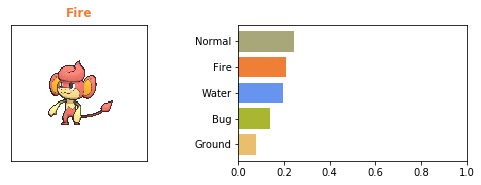

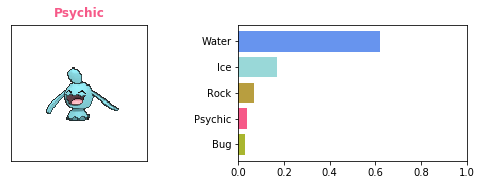

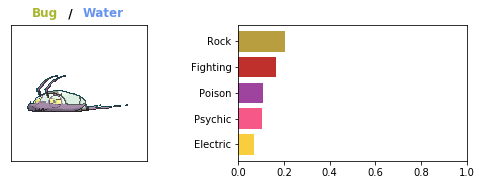

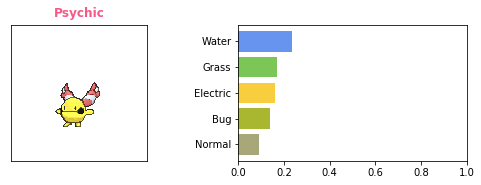

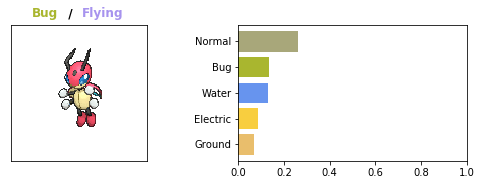

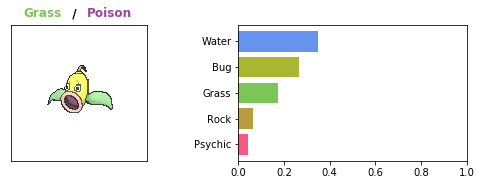

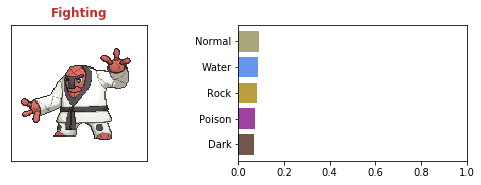

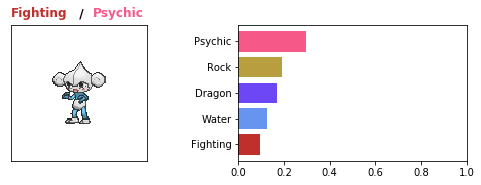

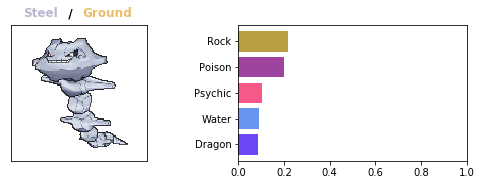

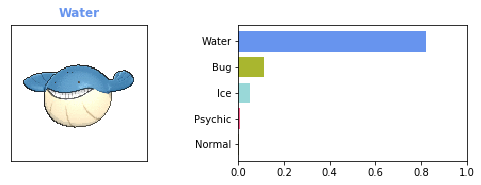

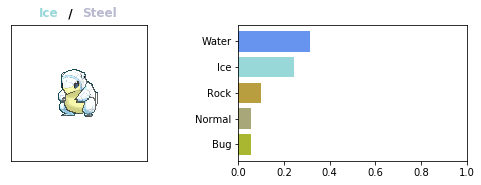

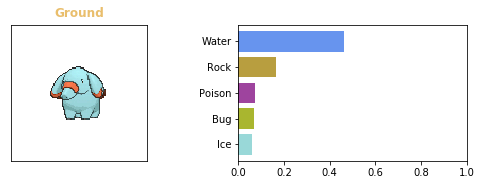

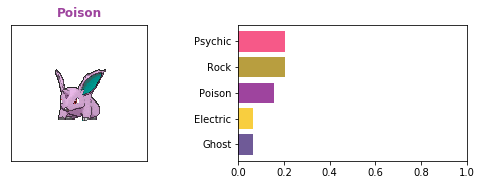

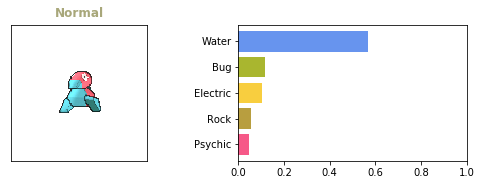

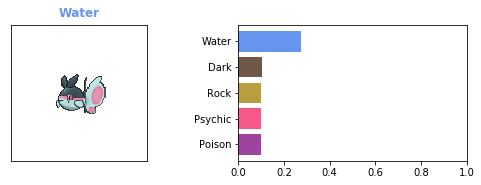

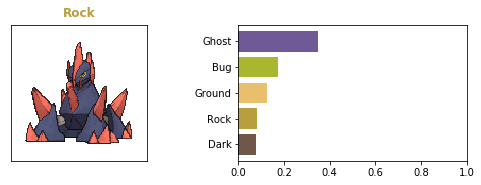

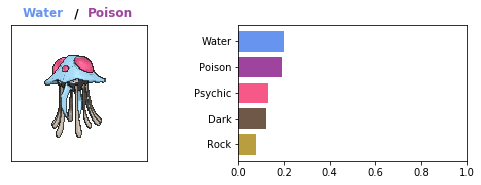

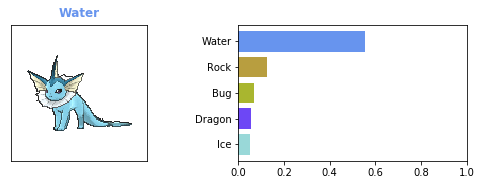

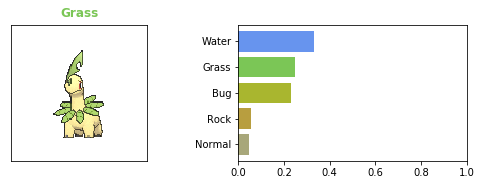

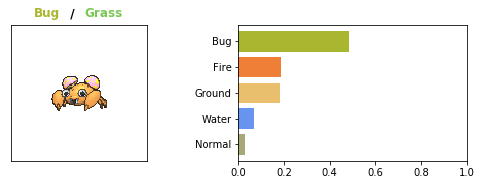

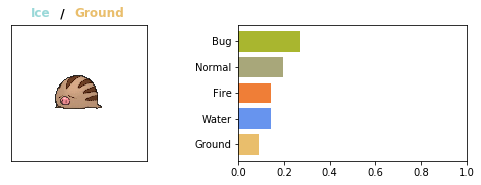

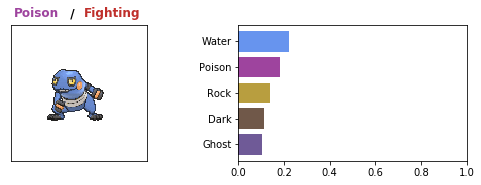

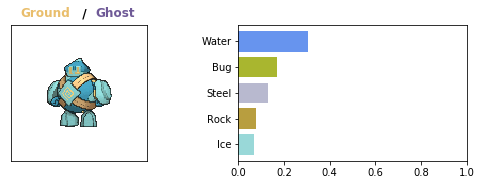

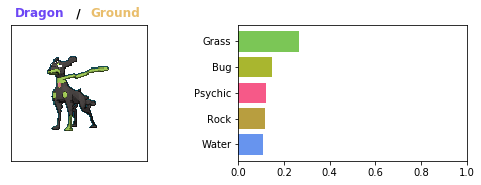

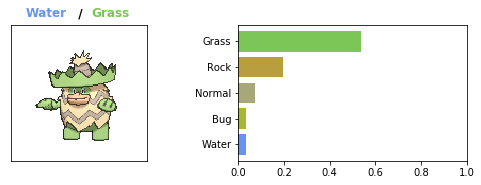

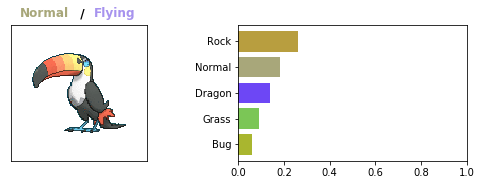

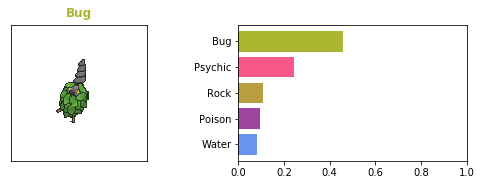

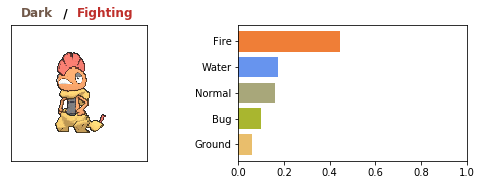

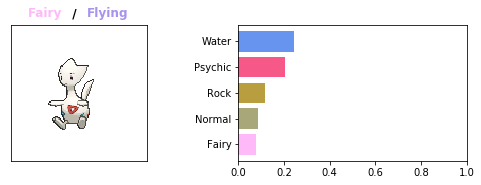

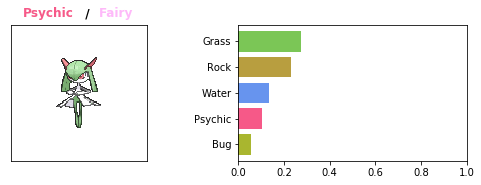

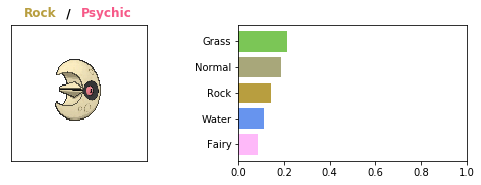

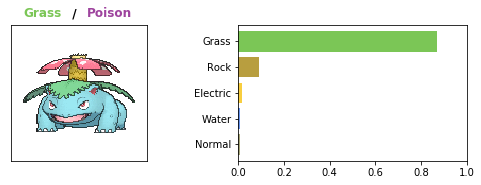

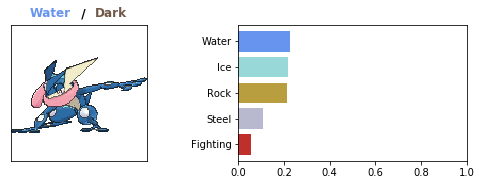

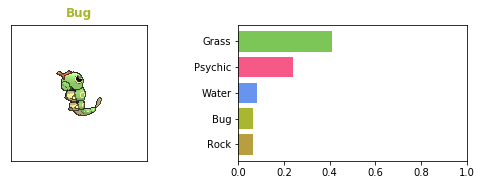

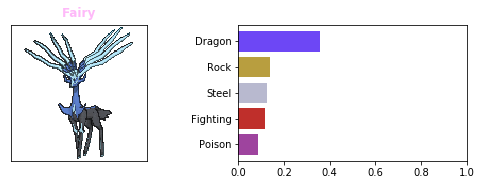

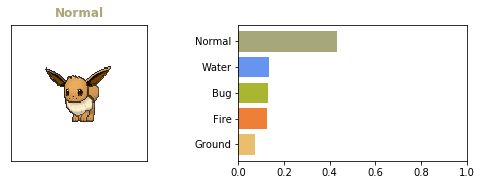

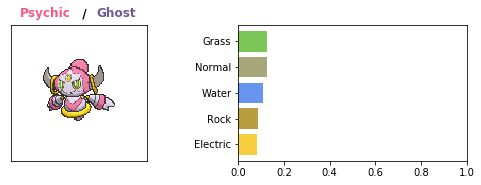

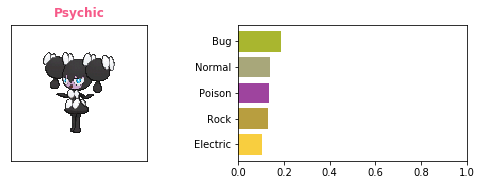

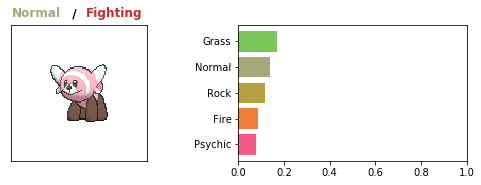

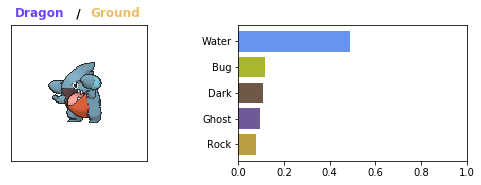

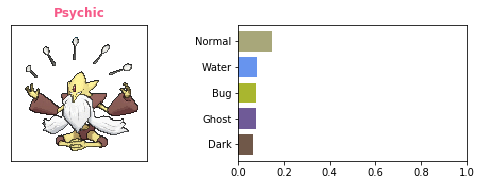

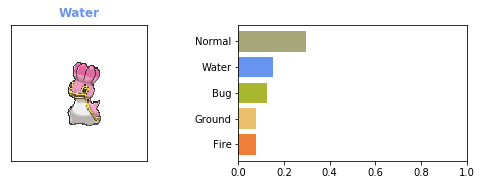

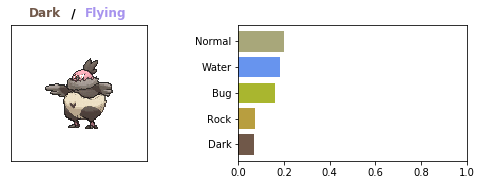

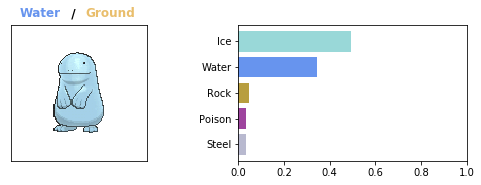

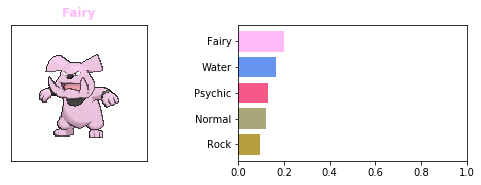

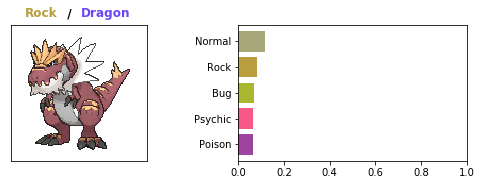

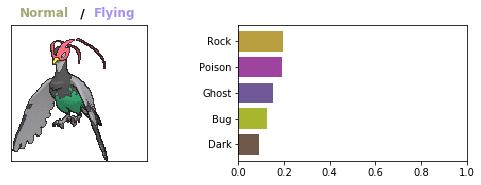

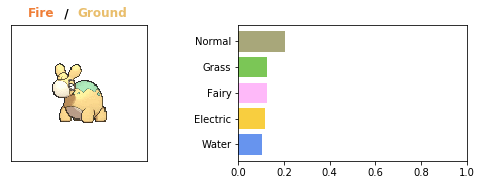

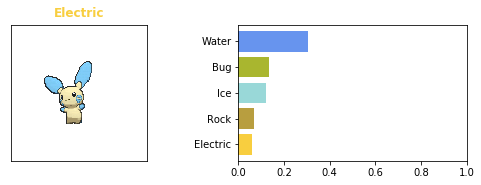

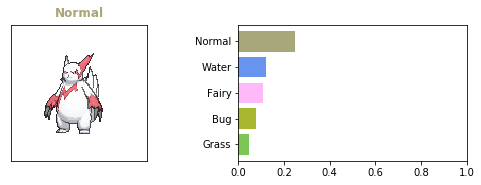

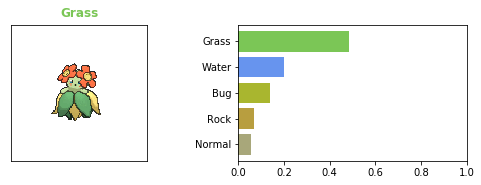

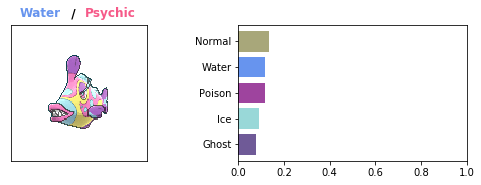

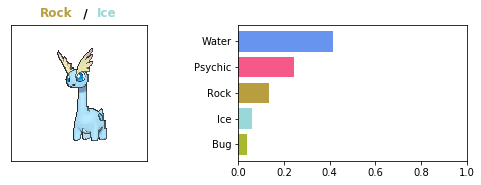

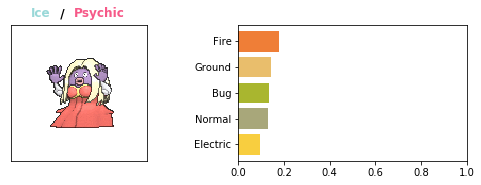

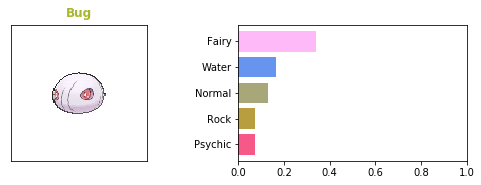

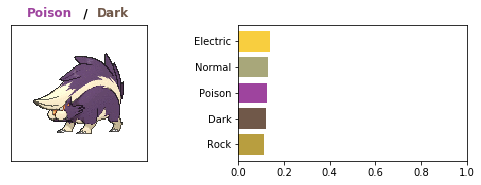

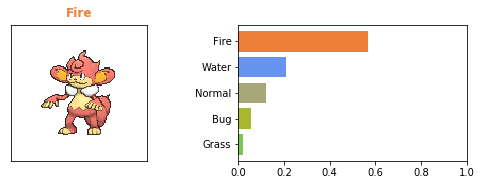

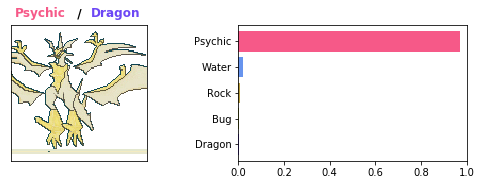

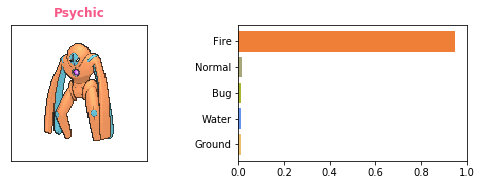

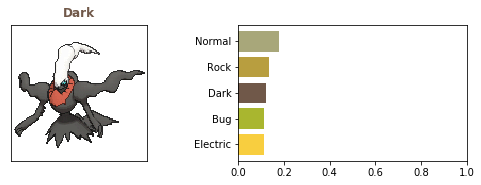

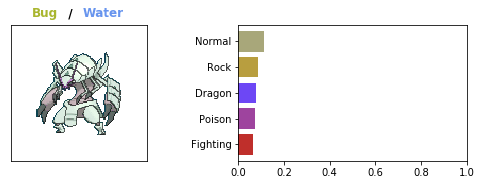

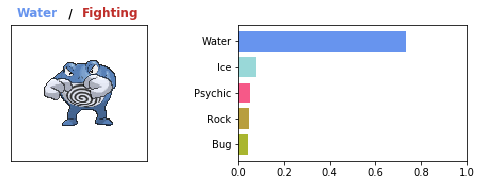

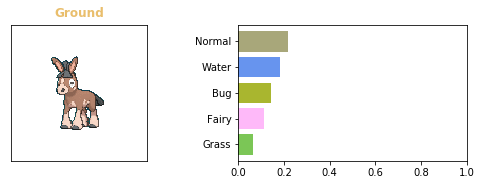

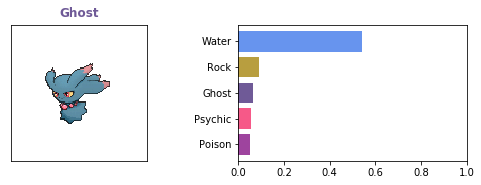

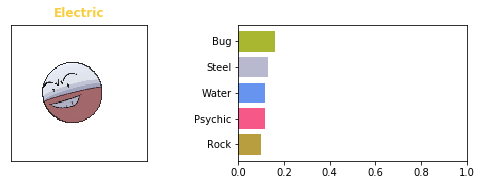

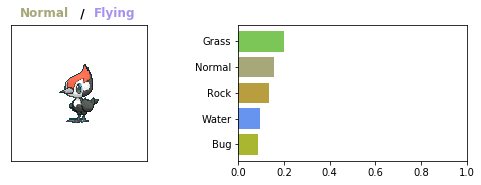

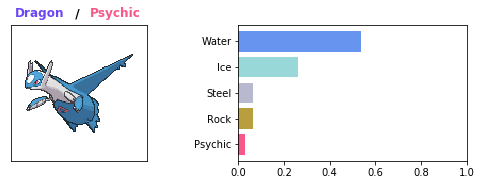

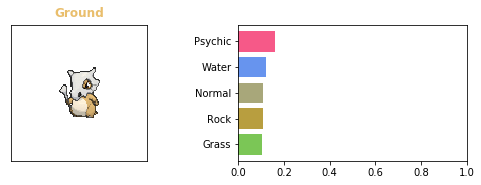

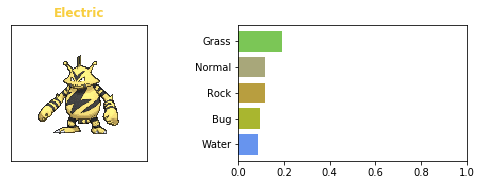

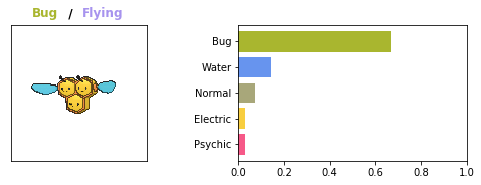

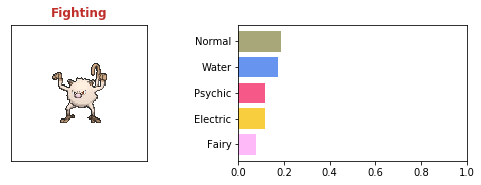

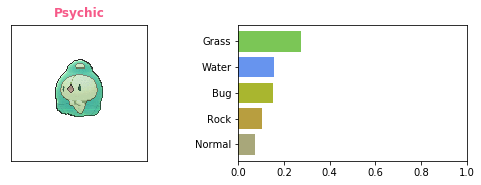

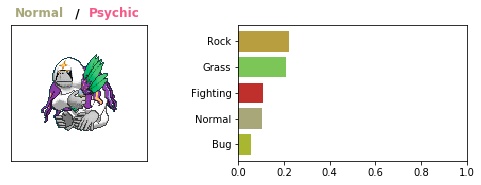

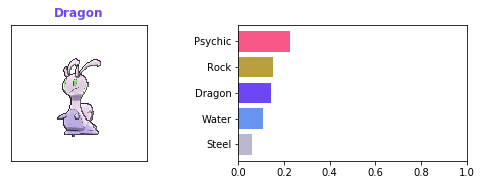

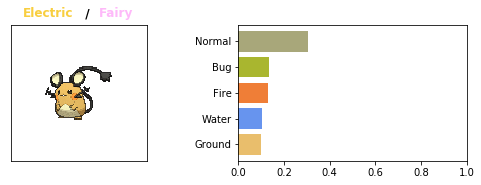

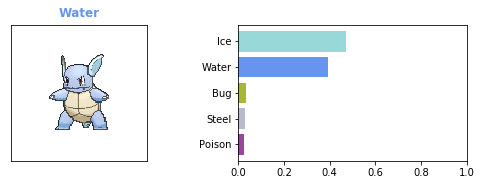

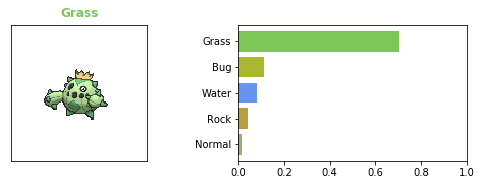

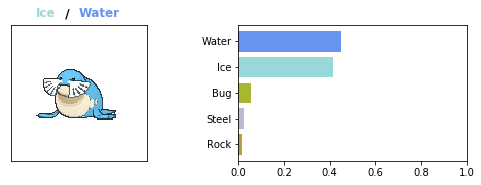

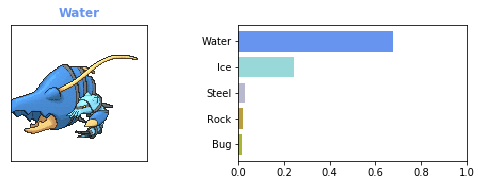

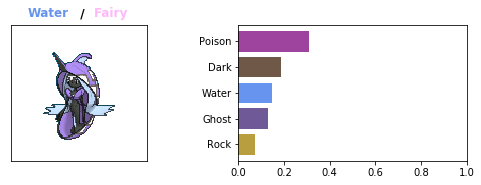

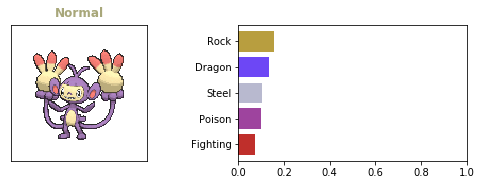

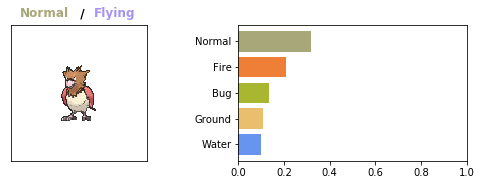

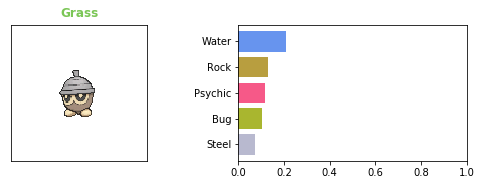

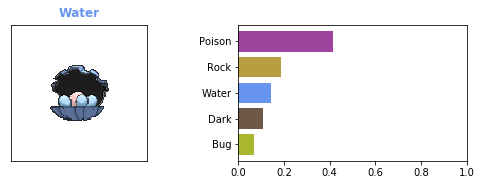

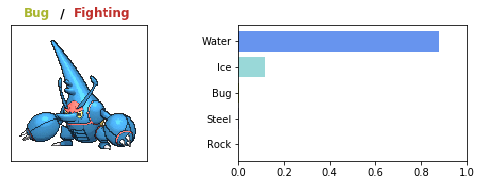

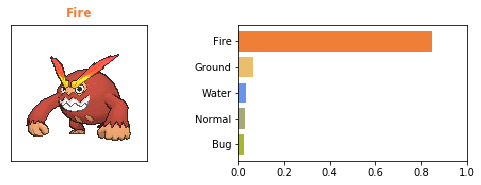

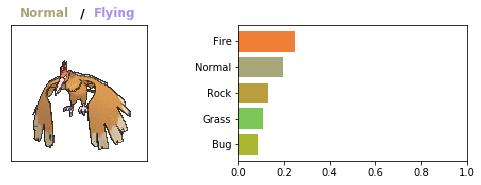

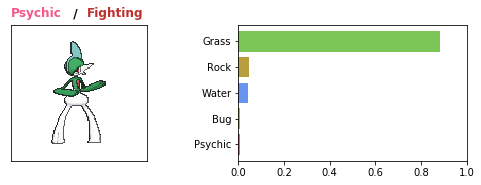

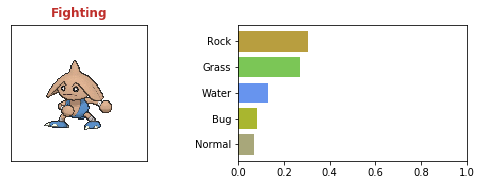

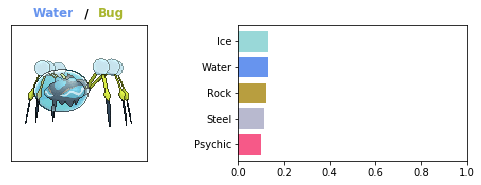

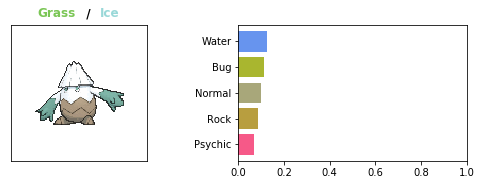

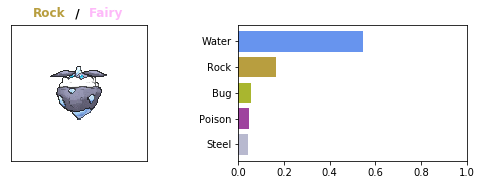

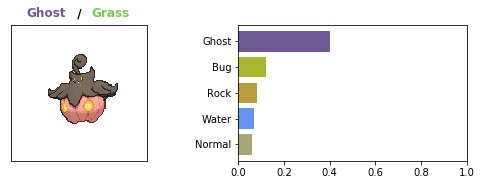

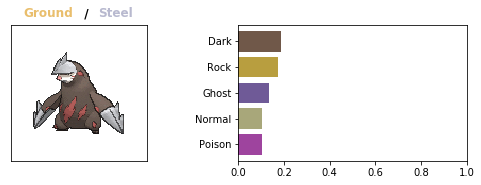

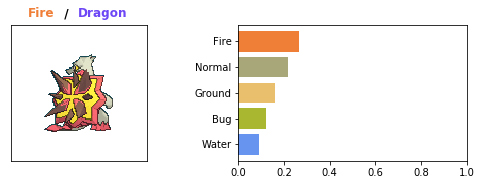

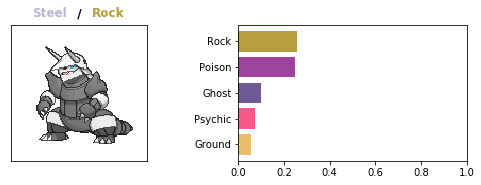

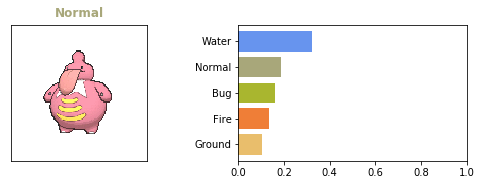

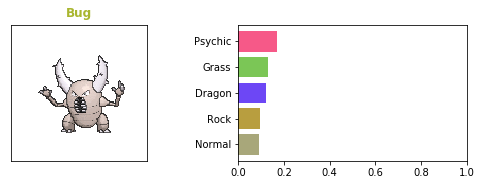

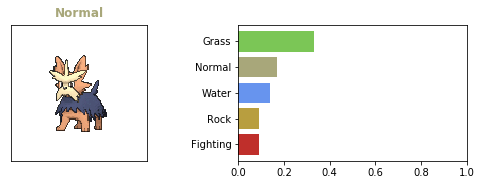

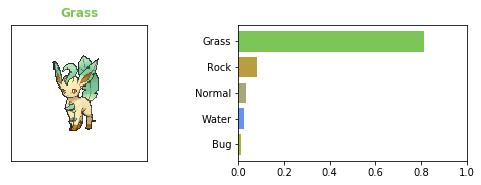

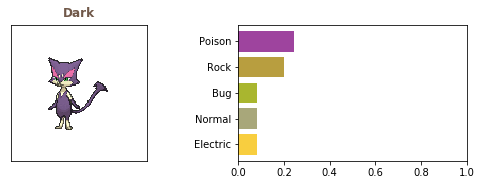

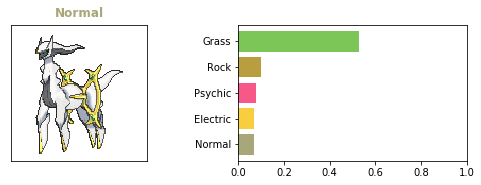

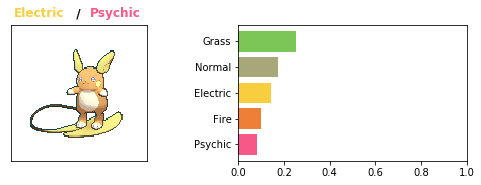

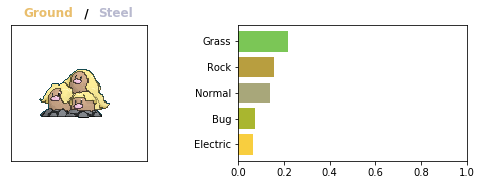

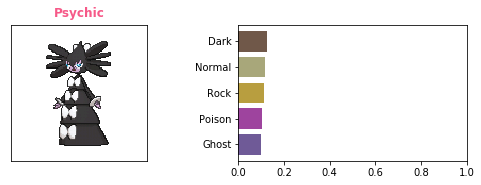

In [81]:
start = 0  # start index
num = 200    # number of images to display
step = 10  # number of frames / pokemon animation

print("Validation predictions")
pp.plotPredictions(x_val_i[start:start+num],
                   y_val_s[start:start+num],
                   val_avg_scores[start:start+num], k=5, y2=y_val_2[start*step:(start+num)*step:step])

In [ ]:
drops = []
regs = []
val_accs = []
train_accs = []

In [34]:
# Test levels of regularization
for i in range(100):
    z = np.random.uniform(-4,-1)
    drop = np.random.uniform(0.3,0.9)
    reg = 10**z
    model = getInitialModel(False, reg=reg, drop=drop)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    batch_size = 64
    aug_factor = 1
    history = model.fit_generator(
        data_aug.flow(x_train_s, oneHot(y_train_s, 18), batch_size=batch_size),
        epochs=1,
        verbose=1,
        validation_data=(x_val_s, oneHot(y_val_s, 18)),
        steps_per_epoch=x_train_s.shape[0] // batch_size * aug_factor
    )
    drops.append(drop)
    regs.append(reg)
    val_accs.append(history.history['val_acc'])
    train_accs.append(history.history['acc'])

Model params: drop = 0.6343125411885072 , reg = 0.000285628045739006
Epoch 1/1
93/93 [==============================] - 173s 2s/step - loss: 2.7892 - acc: 0.1587 - val_loss: 2.7653 - val_acc: 0.1987
Model params: drop = 0.8464474988114334 , reg = 0.011285417782952237
Epoch 1/1
93/93 [==============================] - 173s 2s/step - loss: 3.6437 - acc: 0.1210 - val_loss: 3.1261 - val_acc: 0.1258
Model params: drop = 0.615575854296694 , reg = 0.06863796532277669
Epoch 1/1
93/93 [==============================] - 173s 2s/step - loss: 5.7658 - acc: 0.1117 - val_loss: 3.7540 - val_acc: 0.1192
Model params: drop = 0.7283920959029615 , reg = 0.0010320250743537014
Epoch 1/1
93/93 [==============================] - 173s 2s/step - loss: 3.0207 - acc: 0.1116 - val_loss: 2.9148 - val_acc: 0.1258
Model params: drop = 0.36801688014801276 , reg = 0.0009135010046947031
Epoch 1/1
93/93 [==============================] - 173s 2s/step - loss: 2.8982 - acc: 0.1467 - val_loss: 2.8557 - val_acc: 0.1854
Mode

KeyboardInterrupt: 

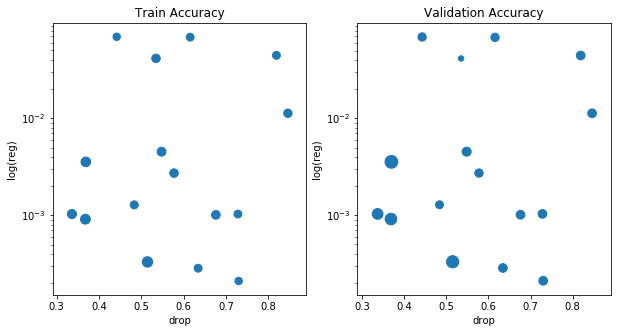

In [66]:
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1,2)

for i in range(2):
    t = None
    accs = None
    if i == 0:
        t = "Train"
        accs = train_accs
    else:
        t = "Validation"
        accs = val_accs
        
    ax = plt.subplot(gs[i])
    ax.set_title(t + " Accuracy")
    ax.set_xlabel("drop")
    ax.set_ylabel("log(reg)")
    ax.set_yscale('log')
    ax.scatter(np.array(drops), np.array(regs), s=(np.array(accs)-.05)*1e3)
plt.show()